In [64]:
import math
from copy import deepcopy
import random
import chess
from ChessWrapper import ChessWrapper
import time
import signal
import chess.pgn
from material_values import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from stockfish import Stockfish
sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')

In [3]:
# better moves higher values
def move_value(board, move):
    if move.promotion is not None:
        return float("inf")

    _piece = board.piece_at(move.from_square)

    # endgame if neither side has a queen
    endgame = True if (board.pieces(chess.QUEEN, chess.BLACK) == 0 and board.pieces(chess.QUEEN, chess.WHITE) == 0) else False
        
    if _piece:
        _from_value = evaluate_piece(_piece, move.from_square, endgame)
        _to_value = evaluate_piece(_piece, move.to_square, endgame)
        position_change = _to_value - _from_value
    else:
        raise Exception(f"A piece was expected at {move.from_square}")

    capture_value = 0.0
    if board.is_capture(move):
        capture_value = evaluate_capture(board, move)

    check_value = 0.0
    if board.gives_check(move):
        check_value = 50.0

    current_move_value = capture_value + position_change + check_value

    return current_move_value


def evaluate_capture(board: chess.Board, move: chess.Move) -> float:
    """
    Given a capturing move, weight the trade being made.
    """
    if board.is_en_passant(move):
        return BASE_VALUES[chess.PAWN]
    _to = board.piece_at(move.to_square)
    _from = board.piece_at(move.from_square)
    if _to is None or _from is None:
        raise Exception(
            f"Pieces were expected at _both_ {move.to_square} and {move.from_square}"
        )
    return BASE_VALUES[_to.piece_type] - BASE_VALUES[_from.piece_type]

def evaluate_piece(piece, square, endgame):
    if piece.color == chess.WHITE:
        if endgame:
            return EG_MAP[piece.piece_type][56 ^ square]

        return MG_MAP[piece.piece_type][56 ^ square]
    else:
        if endgame:
            return EG_MAP[piece.piece_type][square]
        
        return MG_MAP[piece.piece_type][square]

In [4]:
def get_ordered_moves(board, moves):
    """
    Get legal moves.
    Attempt to sort moves by best to worst.
    Use piece values (and positional gains/losses) to weight captures.
    """
    def orderer(move):
        return move_value(board, move)

    in_order = sorted(
        moves, key=orderer, reverse=True
    )
    return list(in_order)


In [5]:
def alphabeta(depth, qdepth, board, alpha, beta, is_max):
    if board.is_checkmate():
        return -24000 if is_max else 24000 # TODO: no magic variable pls

    # game is over but not checkmate, so it's a draw
    elif board.is_game_over():
        return 0

    # zhash = chess.polyglot.zobrist_hash(board)
    # if zhash in TT:
    #      return TT[zhash]

    if depth <= 0:
        qsearch_val = qsearch(qdepth, board, alpha, beta, is_max)
        # TT[zhash] = qsearch_val
        return qsearch_val

    if is_max:
        best_val = float('-inf')
        moves = get_ordered_moves(board, board.get_legal_moves())
        
        
        for move in moves:
                
            board.push(move)
            v = alphabeta(depth - 1, qdepth, board, alpha, beta, not is_max)

            if v > 23000:
                v -= 1
            elif v < -23000:
                v += 1
                
            best_val = max(best_val, v)
            alpha = max(alpha, best_val)
            board.pop()
            if beta <= alpha:
                break
        return best_val
    else:
        best_val = float('+inf')
        moves = get_ordered_moves(board, board.get_legal_moves())
        for move in moves:
            board.push(move)
            v = alphabeta(depth - 1, qdepth, board, alpha, beta, not is_max)
            if v > 23000:
                v -= 1
            elif v < -23000:
                v += 1
            best_val = min(best_val, v)
            beta = min(beta, best_val)
            board.pop()
            if beta <= alpha:
                break
        return best_val
        

In [6]:
MVV_LVA = [
    [0, 0, 0, 0, 0, 0, 0],       # victim K, attacker K, Q, R, B, N, P, None
    [50, 51, 52, 53, 54, 55, 0], # victim Q, attacker K, Q, R, B, N, P, None
    [40, 41, 42, 43, 44, 45, 0], # victim R, attacker K, Q, R, B, N, P, None
    [30, 31, 32, 33, 34, 35, 0], # victim B, attacker K, Q, R, B, N, P, None
    [20, 21, 22, 23, 24, 25, 0], # victim N, attacker K, Q, R, B, N, P, None
    [10, 11, 12, 13, 14, 15, 0], # victim P, attacker K, Q, R, B, N, P, None
    [0, 0, 0, 0, 0, 0, 0],       # victim None, attacker K, Q, R, B, N, P, None
]

In [7]:
def mvv_lva_idx(piece_type):
    if piece_type == chess.KING:
        return 0
    elif piece_type == chess.QUEEN:
        return 1
    elif piece_type == chess.ROOK:
        return 2
    elif piece_type == chess.BISHOP:
        return 3
    elif piece_type == chess.KNIGHT:
        return 4
    elif piece_type == chess.PAWN:
        return 5
    else:
        return 6

In [8]:
def mvv_lva(board, move):

    atk_piece = board.piece_at(move.from_square)
    def_piece = board.piece_at(move.to_square)

    if atk_piece is None or def_piece is None:
        return 0
        
    atk_idx = mvv_lva_idx(atk_piece.piece_type)
    def_idx = mvv_lva_idx(def_piece.piece_type)
    return MVV_LVA[def_idx][atk_idx]

In [9]:
def get_ordered_captures(board, moves):
    """
    Get legal moves.
    Attempt to sort moves by best to worst.
    Use piece values (and positional gains/losses) to weight captures.
    """
    def orderer(move):
        return mvv_lva(board, move)

    in_order = sorted(
        moves, key=orderer, reverse=True
    )
    return list(in_order)

In [10]:
def qsearch(depth, board, alpha, beta, is_max):
    if depth <= 0:
        return alpha if is_max else beta
    stand_pat = board.eval()
    if is_max:
        if stand_pat >= beta:
            return beta
        if stand_pat >= alpha:
            alpha = stand_pat
        moves = board.get_legal_moves()
        captures = [move for move in moves if board.is_capture(move)]
        ordered_captures = get_ordered_captures(board, captures)
        
        for move in ordered_captures:
            board.push(move)
            score = qsearch(depth - 1, board, alpha, beta, not is_max)
            board.pop()
            if score >= beta:
                return beta # original: return score?
            if score > alpha:
                alpha = score
        return alpha
    else:
        if stand_pat <= alpha:
            return alpha
        if stand_pat <= beta:
            beta = stand_pat
        moves = board.get_legal_moves()
        captures = [move for move in moves if board.is_capture(move)]
        ordered_captures = get_ordered_captures(board, captures)
        
        for move in ordered_captures:
            board.push(move)
            score = qsearch(depth - 1, board, alpha, beta, not is_max)
            board.pop()
            if score <= alpha:
                return alpha # original: return score?
            if score < beta:
                beta = score
        return beta

In [11]:
b = ChessWrapper()

In [12]:
alphabeta(4, 6, b, float('-inf'), float('+inf'), True)

0.0

In [13]:
def find_best_move(board, depth, qdepth):
    is_max = (board.get_turn() == chess.WHITE)
    best_val = float('-inf') if is_max else float('+inf')

    if board.is_checkmate():
        return (None, -24000) if is_max else (None, 24000) # TODO: no magic variable pls

    # game is over but not checkmate, so it's a draw
    elif board.is_game_over():
        return (None, 0)
    
    moves = board.get_legal_moves()
    best_move = moves[0]
    for move in moves:
        board.push(move)
        # TTs are weird
        #move_val = alphabeta(depth - 1, board, float('-inf'), float('+inf'), not is_max, {})
        move_val = alphabeta(depth - 1, qdepth, board, float('-inf'), float('+inf'), not is_max)

        board.pop()
        if is_max and move_val > best_val:
            best_move = move
            best_val = move_val
        elif not is_max and move_val < best_val:
            best_move = move
            best_val = move_val
    return best_move, best_val

In [14]:
def self_play(depth=4, qdepth=6):
    # self-play
    b = ChessWrapper()
    game = chess.pgn.Game()
    game.headers["Event"] = "depth 4"
    node = None
    wtm = True
    while True:
        if b.is_game_over():
            break
        if wtm:
            m, v = find_best_move(b, depth, qdepth)
        else:
            m, v = find_best_move(b, depth, qdepth)

        print('move is: ' + str(b.san(m)) + ' | eval is: ' + str(v))
        print('-' * 15)
        b.push(m)
        wtm = not wtm
        if node is None:
            node = game.add_variation(m)
        else:
            node = node.add_variation(m)
        print(b)
        print('-' * 15)
    return b.outcome(), game

In [15]:
#sp_outcome, sp_game = self_play()

In [16]:
#print(sp_game, file=open('d4d4.pgn', 'w'), end='\n\n')

In [17]:
def vs_person(wtm=True):
    b = ChessWrapper()
    game = chess.pgn.Game()
    game.headers["Event"] = "depth 4"
    node = None

    while True:
        if b.is_game_over():
            break
        if wtm:
            m, v = find_best_move(b, 4, 6)
        else:
            m = None
            while m is None:
                try:
                    input_move = input('What is the next move? \n')
                    m = b.parse_san(input_move)
                except Exception as e:
                    m = None
            v = None

        print('move is: ' + str(b.san(m)) + ' | eval is: ' + str(v))
        print('-' * 15)
        b.push(m)
        wtm = not wtm
        if node is None:
            node = game.add_variation(m)
        else:
            node = node.add_variation(m)
        print(b)
        print('-' * 15)
    return b.outcome(), game

In [56]:
# wtm = True means alpha beta moves first, and is white
def vs_sf(elo=1400, depth=4, qdepth=6, wtm=True, fen=None):
    
    if fen is None:
        b = ChessWrapper()

        sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
        sf.set_elo_rating(elo)
    else:
        b = ChessWrapper(fen)
        sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
        sf.set_fen_position(fen)
        sf.set_elo_rating(elo)
    
    game = chess.pgn.Game()
    game.headers["Event"] = "sf elo: " + str(elo) + ', depth: ' + str(depth) + ', qdepth: ' + str(qdepth)
    
    if fen is not None:
        game.setup(fen)
        
    node = None

    while True:
        if b.is_game_over():
            break
        if wtm:
            m, v = find_best_move(b, depth, qdepth)
        else:
            m, v = chess.Move.from_uci(sf.get_best_move()), None

        b.push(m)
        sf.make_moves_from_current_position([str(m)])
        
        
        
        if node is None:
            node = game.add_variation(m)
        else:
            node = node.add_variation(m)
        
#         if wtm:
#             print('alpha-beta move')
#         else:
#             print('sf move')

#         print(b)
#         print('-' * 15)
        wtm = not wtm
    return b.outcome(), game

In [20]:
#sc_oc, sc_game = vs_sf(elo=200, wtm=True, fen='rnbqkb1r/pp2pppp/3p1n2/8/3NP3/8/PPP2PPP/RNBQKB1R w KQkq - 1 5')

In [21]:
# test = pd.DataFrame(columns=['depth', 'qdepth', 'elo', 'game'])
# new_row = {'depth':4, 'qdepth':6, 'elo':2, 'game':sc_game}
# test = test._append(new_row, ignore_index=True)

In [22]:
# print(sc_game, file=open('d4_200_sc.pgn', 'w'), end='\n\n')

In [57]:
def est_elo(ab_depth=4, ab_qdepth=6):
    
    # sicilian (open), queen's indian, reti transposed to english
    openings = [
        'rnbqkb1r/pp2pppp/3p1n2/8/3NP3/8/PPP2PPP/RNBQKB1R w KQkq - 1 5',
        'rn1qkb1r/p1pp1ppp/bp2pn2/8/2PP4/5NP1/PP2PP1P/RNBQKB1R w KQkq - 1 5',
        'rnbqk2r/ppp1ppbp/3p1np1/8/2P1P3/2N2N2/PP1P1PPP/R1BQKB1R w KQkq - 0 5'
    ]
    
    random.shuffle(openings)
    
    lo = 0
    hi = 3200
    
    df = pd.DataFrame(columns = ['depth', 'qdepth', 'lo', 'hi', 'elo', 'outcome', 'game'])
    
    for i in range(5):
        mid = (lo + hi) // 2
        ab_score = 0
        sf_score = 0
        
        # play 3 pairs
        for i in range(3):
            
            print('-' * 15)
            print(ab_depth, ab_qdepth, mid)
            # alpha beta plays white
            ab_white_oc, ab_white_game = vs_sf(elo=mid, depth=ab_depth, qdepth=ab_qdepth, wtm=True, fen=openings[i])
            
            if ab_white_oc.winner == chess.WHITE:
                ab_score += 1
            elif ab_white_oc.winner == chess.BLACK:
                sf_score += 1
            else:
                ab_score += 0.5
                sf_score += 0.5
                
            new_row = {'depth': ab_depth, 'qdepth': ab_qdepth, 'lo': lo, 'hi': hi, 'elo': mid, 'outcome': ab_white_oc.winner != chess.BLACK, 'game': ab_white_game}
            df = df._append(new_row, ignore_index=True)
            print(ab_white_oc)
            
            # if either player cuts off early, don't need to play the rest
            if ab_score >= 3.5 or sf_score >= 3.5:
                break
                
            print('-' * 15)
            print(ab_depth, ab_qdepth, mid)
                
            # alpha beta plays black
            ab_black_oc, ab_black_game = vs_sf(elo=mid, depth=ab_depth, qdepth=ab_qdepth, wtm=False, fen=openings[i])
            
            if ab_black_oc.winner == chess.BLACK:
                ab_score += 1
            elif ab_black_oc.winner == chess.WHITE:
                sf_score += 1
            else:
                ab_score += 0.5
                sf_score += 0.5
                
            new_row = {'depth': ab_depth, 'qdepth': ab_qdepth, 'lo': lo, 'hi': hi, 'elo': mid, 'outcome': ab_black_oc.winner != chess.WHITE, 'game': ab_black_game}
            df = df._append(new_row, ignore_index=True)
            print(ab_black_oc)
            
            # if either player cuts off early, don't need to play the rest
            if ab_score >= 3.5 or sf_score >= 3.5:
                break
                
        if ab_score >= 3:
            lo = mid
        else:
            hi = mid
            
    return df, lo, hi

In [ ]:
df1 = pd.DataFrame(columns = ['depth', 'lo', 'hi'])

In [32]:
# fix q search depth, try alpha-beta depth 1, 2, 3, 4

df_results = pd.DataFrame(columns = ['depth', 'lo', 'hi'])
df_games = pd.DataFrame(columns = ['depth', 'qdepth', 'lo', 'hi', 'elo', 'outcome', 'game'])

for d in range(1, 5):
    df, lo, hi = est_elo(ab_depth=d, ab_qdepth=6)
    new_row = {'depth': d, 'lo': lo, 'hi': hi}
    df_results = df_results._append(new_row, ignore_index=True)
    df_games = pd.concat([df_games, df])
    print(df_results)
    print(df_games)

---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 2000
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 2000
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 2000
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 2000
Outcome(termination=<Ter

Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 1600
Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 2400
Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
---------------
3 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 2400
Outcome(termination=<Termination.FIVEFOLD_REPETITION: 5>, winner=None)
---------------
3 6 2400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 2000
Outcome(terminatio

KeyboardInterrupt: 

In [33]:
df_results

,depth,lo,hi
0,1,2000,2100
1,2,1500,1600
2,3,2000,2100


In [41]:
df_games

,index,depth,qdepth,lo,hi,elo,outcome,game
0,0,1,6,0,3200,1600,True,"[Event ""sf elo: 1600, depth: 1, qdepth: 6""]\n[..."
1,1,1,6,0,3200,1600,True,"[Event ""sf elo: 1600, depth: 1, qdepth: 6""]\n[..."
2,2,1,6,0,3200,1600,True,"[Event ""sf elo: 1600, depth: 1, qdepth: 6""]\n[..."
3,3,1,6,0,3200,1600,True,"[Event ""sf elo: 1600, depth: 1, qdepth: 6""]\n[..."
4,4,1,6,1600,3200,2400,False,"[Event ""sf elo: 2400, depth: 1, qdepth: 6""]\n[..."
...,...,...,...,...,...,...,...,...
69,19,3,6,2000,2400,2200,False,"[Event ""sf elo: 2200, depth: 3, qdepth: 6""]\n[..."
70,20,3,6,2000,2200,2100,False,"[Event ""sf elo: 2100, depth: 3, qdepth: 6""]\n[..."
71,21,3,6,2000,2200,2100,False,"[Event ""sf elo: 2100, depth: 3, qdepth: 6""]\n[..."
72,22,3,6,2000,2200,2100,False,"[Event ""sf elo: 2100, depth: 3, qdepth: 6""]\n[..."


In [46]:
df_games.loc[0].game.end().board().outcome().winner

True

In [52]:
df_games.loc[0].game.headers['Event'].split(',')

['sf elo: 1600', ' depth: 1', ' qdepth: 6']

In [55]:
for i in range(73):
    game = df_games.loc[i].game
    outcome = df_games.loc[i].outcome
    game_result = game.end().board().outcome().winner
    
    sf_elo = game.headers['Event'].split(',')[0]
    
    if game_result == chess.WHITE:
        if outcome == True:
            # ab won as white
            new_event_header = "alpha-beta: depth 4 & qdepth 6 (white) vs " + sf_elo + " (black), alpha-beta wins"
            filename = 'ab_w_win_vs_' + sf_elo + '.pgn'
        else:
            # sf won as white
            new_event_header = sf_elo + " (white) vs alpha-beta depth 4 & qdepth 6 (black), sf wins"
            filename = sf_elo + '_w_win_vs_ab.pgn'
            
    elif game_result == chess.BLACK:
        if outcome == True:
            # ab won as black
            new_event_header = sf_elo + " (white) vs alpha-beta: depth 4 & qdepth 6 (black), alpha-beta wins"
            filename = 'ab_b_win_vs_' + sf_elo + '.pgn'
        else:
            # sf won as black
            new_event_header = "alpha-beta: depth 4 & qdepth 6 (white) vs " + sf_elo + " (black), sf wins"
            filename = sf_elo + '_b_win_vs_ab.pgn'
    else:
        continue
    game.headers['Event'] = new_event_header
    print(game, file=open('d4_test/' + filename, "w"), end="\n\n")
    

In [58]:
# fix q search depth, try alpha-beta depth 1, 2, 3, 4

df_results2 = pd.DataFrame(columns = ['depth', 'lo', 'hi'])
df_games2 = pd.DataFrame(columns = ['depth', 'qdepth', 'lo', 'hi', 'elo', 'outcome', 'game'])

for d in range(1, 4):
    df, lo, hi = est_elo(ab_depth=d, ab_qdepth=6)
    new_row = {'depth': d, 'lo': lo, 'hi': hi}
    df_results2 = df_results2._append(new_row, ignore_index=True)
    df_games2 = pd.concat([df_games2, df])
    print(df_results2)
    print(df_games2)

---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
1 6 400
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
1 6 400
Outcome(termination=<Termination

Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 1600
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)
---------------
3 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)
---------------
3 6 800
Outcome(termination=<Termination.CHECKMATE: 1>, winner=

In [60]:
chart_data = pd.DataFrame({'Depth': [1, 2, 3, 4], 'ELO': [50, 350, 1550, 2050], 'error': [50, 50, 50, 50]})

<Axes: xlabel='Depth'>

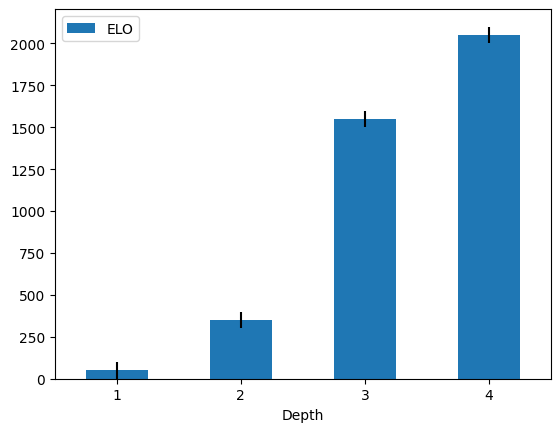

In [65]:
chart_data.plot(kind='bar', x='Depth', y='ELO', yerr='error', rot=0)